# 프로젝트 - Movielens 영화 SBR

목표 : Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보기.


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

---------------------------------------------------------------------------------------------------

<img src="./images/E17/e17-Rubric.png"></img>  

-----------------------------------------------------------------

## Step 0. 데이터 가져오기  

1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip  



In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data['Time'] = data['Time'].map(lambda x: pd.Timestamp(x, unit='s')) # Timestamp 형식으로 변형해서 데이터를 준비합니다. 
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 데이터 EDA 

UserId 와 ItemId 의 유일한 갯수

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

UserId 별 데이터는 몇 개인지 확인

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

itemId 별 데이터가 몇 개인지 확인

In [5]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [64]:
item_length.median(), item_length.mean()

(123.5, 269.88909875876953)

UserId별 시간(초)당 데이터는 몇 개인지 확인

In [6]:
user_time_length = data.groupby(['UserId', 'Time']).size()
user_time_length

UserId  Time               
1       2000-12-31 22:00:19    1
        2000-12-31 22:00:55    3
        2000-12-31 22:01:43    1
        2000-12-31 22:02:52    1
        2000-12-31 22:04:35    1
                              ..
6040    2001-08-10 14:39:58    1
        2001-08-10 14:40:29    1
        2001-08-10 14:41:04    2
        2001-08-10 14:41:26    1
        2001-08-20 13:44:15    1
Length: 471163, dtype: int64

한 사용자가 시간(초)당 item에 Rating을 부여하는 액션을 몇번을 취했는지 확인할 수 있다. 시간(초)당 액션 수가 비정상적으로 많다면 의심을 해봐야겠습니다.

In [7]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [8]:
user_length.min(), user_length.max()

(20, 2314)

In [9]:
user_time_length.median(), user_time_length.mean()

(2.0, 2.1228513274599234)

In [10]:
user_time_length.min(), user_time_length.max()

(1, 30)

사용자별 시간(초)별 보통의 액션은 2번 정도인데, 같은 시간(초)에 30번 이상 Rating을 부여하는 액션을 취한 것은 이상해 보입니다.

In [11]:
user_length.quantile(0.999)

1343.181000000005

In [12]:
user_time_length.quantile(0.999)

10.0

사용자별 시간(초)별 Rating한 액션을 봤을 때 99.9%가 10이하입니다. 같은 사용자가 동일한 시간(초)에 10이상 Rating을 한다는 것은 가능한 것일까요? 비정상적인 액션같습니다.
아래에 동일 사용자가 동일한 시간(초) 최대 30번 Rating을 한 데이터를 조회해 봤습니다. 각기 다른 itemid에 rating 도 다양하게 부여되었습니다. 동일 초단위 시간에 다른 내용의 액션이 되었다는건 부적절한 행위가 유입된 듯 보입니다.

In [13]:
long_user = user_time_length[user_time_length==30].index[0]
data[(data['UserId']==long_user[0]) & (data['Time'] == long_user[1])]

,UserId,ItemId,Rating,Time
112231,731,3044,4,2000-11-29 20:06:42
112251,731,1455,3,2000-11-29 20:06:42
112305,731,1639,5,2000-11-29 20:06:42
112311,731,3244,4,2000-11-29 20:06:42
112323,731,1656,2,2000-11-29 20:06:42
112342,731,3426,4,2000-11-29 20:06:42
112348,731,1829,2,2000-11-29 20:06:42
112379,731,2675,4,2000-11-29 20:06:42
112476,731,802,3,2000-11-29 20:06:42
112478,731,803,5,2000-11-29 20:06:42


한 사용자가 동일 시간(초)에 몇번의 액션을 취했는지(Rating을 했는지) 시각화를 통해 알아봅니다. 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [14]:
length_count = user_time_length.groupby(user_time_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

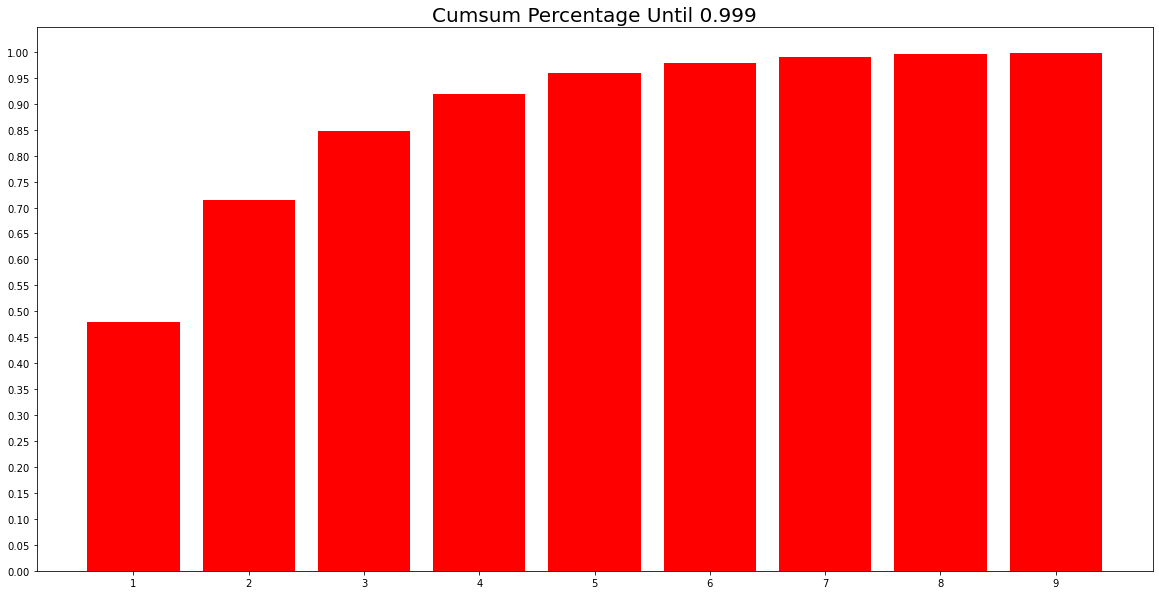

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### 1-1. 데이터 Cleansing  
데이터 전처리는 분석자의 판단에 달려있는데, 이번 분석에서는 UserId별 시간(초)별 중복이 있는 데이터는 삭제하도록 합니다.

In [17]:
data=data.drop_duplicates(subset=['UserId', 'Time'], keep='first')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


Rating이 낮은 경우는 추천하지 않고, Rating 이 높은 4, 5만 추천하도록 합니다. 

In [18]:
idx_rating = data[data['Rating']<4].index
data = data.drop(idx_rating)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


unpopular item을 제거하기

In [19]:
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
data = cleanse_unpopular_item(data, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


### 1.2. Train/ Valid/ Test split

In [21]:
data.sort_values(by=['Time'], inplace=True) 
data.shape

(271785, 4)

In [36]:
# split
tr = data[:250000]
val = data[250000:270000]
test = data[270000:]

In [13]:
"""
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date
"""

In [10]:
#tr, test = split_by_date(data, n_days=10) # 최종 날짜로부터 10일 이전 날짜로 Test 데이터를 구성한다.
#tr, val = split_by_date(tr, n_days=10)    # 최종 날짜로부터 30일 이전 날짜로 Val 데이터를 구성한다.

In [37]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')    

In [38]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 250000
	 Users: 6022
	 Items: 2793
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-04-12 14:37:03

* valid Set Stats Info
	 Events: 20000
	 Users: 859
	 Items: 2392
	 First Time : 2001-04-12 15:31:22
	 Last Time : 2002-12-01 18:04:52

* test Set Stats Info
	 Events: 1785
	 Users: 202
	 Items: 993
	 First Time : 2002-12-01 18:06:13
	 Last Time : 2003-02-28 17:49:50



In [39]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [40]:
tr

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000007,6040,1961,4,2000-04-25 23:06:17,2
999868,6040,573,4,2000-04-25 23:07:36,3
999884,6040,912,5,2000-04-25 23:09:51,4
...,...,...,...,...,...
240864,1451,2202,4,2001-04-12 04:12:17,741
241141,1451,2857,5,2001-04-12 04:14:35,148
27773,195,588,5,2001-04-12 05:46:43,44
635661,3832,3897,4,2001-04-12 13:40:32,2716


전처리한 데이터셋 저장하기

In [41]:
save_path = data_path / 'processed_pj'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.



전처리한 데이터셋 불러오기

In [42]:
import pickle
from pathlib import Path
import os

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/processed_pj/processed_pj') 
train_path = data_path / 'train.pkl'
val_path = data_path / 'valid.pkl'
test_path = data_path / 'test.pkl'

# load
with open(train_path, 'rb') as f:
    tr = pickle.load(f)
    
# load
with open(val_path, 'rb') as f:
    val = pickle.load(f)
    
# load
with open(test_path, 'rb') as f:
    test = pickle.load(f)    

In [43]:
tr['UserId'].nunique()

5924

In [44]:
tr.groupby('UserId').count()

,ItemId,Rating,Time,item_idx
UserId,,,,
1,29,29,29,29
2,40,40,40,40
3,21,21,21,21
4,6,6,6,6
5,34,34,34,34
...,...,...,...,...
6036,91,91,91,91
6037,33,33,33,33
6038,11,11,11,11


### 3-1. Indexing

In [45]:
# SessionId -> UserId로 변경
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [46]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000007,6040,1961,4,2000-04-25 23:06:17,2
999868,6040,573,4,2000-04-25 23:07:36,3
999884,6040,912,5,2000-04-25 23:09:51,4
1000186,6040,527,5,2000-04-25 23:10:19,5
999953,6040,649,5,2000-04-25 23:10:57,6
1000108,6040,3289,5,2000-04-25 23:11:45,7
1000083,6040,759,5,2000-04-25 23:14:08,8
999938,6040,2858,4,2000-04-25 23:14:35,9


In [47]:
tr_dataset.click_offsets

array([     0,     29,     69, ..., 254615, 254650, 254756], dtype=int32)

In [48]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5921, 5922, 5923])

### 3-2. SessionDataLoader

In [49]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [24]:
def initialize(batch_size):
    first_iters = np.arange(batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
    last_session = batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
    start = tr_dataset.click_offsets[tr_dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
    end = tr_dataset.click_offsets[tr_dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
    mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
    finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
    return start, end, mask, last_session, finished

In [25]:
initialize(64)

(array([   0,   29,   69,   90,   96,  130,  154,  162,  200,  241,  427,
         478,  484,  502,  511,  563,  567,  608,  703,  792,  803,  805,
         888,  921,  977, 1009, 1089, 1110, 1151, 1164, 1176, 1201, 1220,
        1333, 1389, 1451, 1616, 1637, 1678, 1693, 1710, 1723, 1775, 1789,
        1867, 1898, 1909, 1920, 2006, 2032, 2040, 2049, 2065, 2253, 2265,
        2276, 2300, 2312, 2444, 2502, 2509, 2515, 2646, 2671], dtype=int32),
 array([  29,   69,   90,   96,  130,  154,  162,  200,  241,  427,  478,
         484,  502,  511,  563,  567,  608,  703,  792,  803,  805,  888,
         921,  977, 1009, 1089, 1110, 1151, 1164, 1176, 1201, 1220, 1333,
        1389, 1451, 1616, 1637, 1678, 1693, 1710, 1723, 1775, 1789, 1867,
        1898, 1909, 1920, 2006, 2032, 2040, 2049, 2065, 2253, 2265, 2276,
        2300, 2312, 2444, 2502, 2509, 2515, 2646, 2671, 2689], dtype=int32),
 array([], dtype=float64),
 63,
 False)

In [50]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000007,6040,1961,4,2000-04-25 23:06:17,2
999868,6040,573,4,2000-04-25 23:07:36,3
999884,6040,912,5,2000-04-25 23:09:51,4
1000186,6040,527,5,2000-04-25 23:10:19,5
999953,6040,649,5,2000-04-25 23:10:57,6
1000108,6040,3289,5,2000-04-25 23:11:45,7
1000083,6040,759,5,2000-04-25 23:14:08,8
999938,6040,2858,4,2000-04-25 23:14:35,9


In [51]:
iter_ex = iter(tr_data_loader)

In [52]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 29 67 88]
Label Item Idx are :       [ 1 30 68 59]
Previous Masked Input Idx are []


## Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

### 3-1 Evaluation Metric

In [53]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2 Model Arcitecture

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [55]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k


In [68]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [61]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 2797)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      427350    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 2797)                142647    
Total params: 569,997
Trainable params: 569,997
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [62]:
# SessionId -> UserId
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

**실험1**

In [63]:
# 학습 
# Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=30, k=5)
train_model(model, args)

Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.1] 

	 - Recall@20 epoch 1: 0.071875
	 - MRR@20    epoch 1: 0.014589



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.04]

	 - Recall@20 epoch 2: 0.075000
	 - MRR@20    epoch 2: 0.016230



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.83]

	 - Recall@20 epoch 3: 0.081250
	 - MRR@20    epoch 3: 0.021765



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.64]

	 - Recall@20 epoch 4: 0.087500
	 - MRR@20    epoch 4: 0.023630



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.63]     

	 - Recall@20 epoch 5: 0.096875
	 - MRR@20    epoch 5: 0.028354



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.55]

	 - Recall@20 epoch 6: 0.103125
	 - MRR@20    epoch 6: 0.030227



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.49]     

	 - Recall@20 epoch 7: 0.100000
	 - MRR@20    epoch 7: 0.031525



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.45]     

	 - Recall@20 epoch 8: 0.106250
	 - MRR@20    epoch 8: 0.031433



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.43]

	 - Recall@20 epoch 9: 0.115625
	 - MRR@20    epoch 9: 0.031413



Evaluation:   4%|▎         | 5/140 [00:01<00:29,  4.54it/s]

	 - Recall@20 epoch 10: 0.112500
	 - MRR@20    epoch 10: 0.029242



**실험2**

In [69]:
# 학습 
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=30, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/3888 [00:00<?, ?it/s]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 2797)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      427350    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 2797)                142647    
Total params: 569,997
Trainable params: 569,997
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=7.09]     

	 - Recall@20 epoch 1: 0.065625
	 - MRR@20    epoch 1: 0.012472



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.03]

	 - Recall@20 epoch 2: 0.081250
	 - MRR@20    epoch 2: 0.013499



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.91]

	 - Recall@20 epoch 3: 0.075000
	 - MRR@20    epoch 3: 0.014530



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.74]

	 - Recall@20 epoch 4: 0.087500
	 - MRR@20    epoch 4: 0.018960



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.63]

	 - Recall@20 epoch 5: 0.109375
	 - MRR@20    epoch 5: 0.027703



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.62]     

	 - Recall@20 epoch 6: 0.121875
	 - MRR@20    epoch 6: 0.030334



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.61]

	 - Recall@20 epoch 7: 0.125000
	 - MRR@20    epoch 7: 0.030310



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.52]

	 - Recall@20 epoch 8: 0.115625
	 - MRR@20    epoch 8: 0.032263



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.62]     

	 - Recall@20 epoch 9: 0.121875
	 - MRR@20    epoch 9: 0.031030



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.66]

	 - Recall@20 epoch 10: 0.121875
	 - MRR@20    epoch 10: 0.030402



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0, train_loss=6.54]     

	 - Recall@20 epoch 11: 0.118750
	 - MRR@20    epoch 11: 0.028923



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.07]

	 - Recall@20 epoch 12: 0.121875
	 - MRR@20    epoch 12: 0.027668



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.24]

	 - Recall@20 epoch 13: 0.109375
	 - MRR@20    epoch 13: 0.024985



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.56]

	 - Recall@20 epoch 14: 0.121875
	 - MRR@20    epoch 14: 0.027353



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.33]

	 - Recall@20 epoch 15: 0.131250
	 - MRR@20    epoch 15: 0.027293



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.38]

	 - Recall@20 epoch 16: 0.121875
	 - MRR@20    epoch 16: 0.026568



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.38]

	 - Recall@20 epoch 17: 0.115625
	 - MRR@20    epoch 17: 0.025538



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.32]

	 - Recall@20 epoch 18: 0.112500
	 - MRR@20    epoch 18: 0.025613



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.68]

	 - Recall@20 epoch 19: 0.106250
	 - MRR@20    epoch 19: 0.024492



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.51]

	 - Recall@20 epoch 20: 0.109375
	 - MRR@20    epoch 20: 0.022584



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.37]

	 - Recall@20 epoch 21: 0.109375
	 - MRR@20    epoch 21: 0.022271



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.22]

	 - Recall@20 epoch 22: 0.112500
	 - MRR@20    epoch 22: 0.022802



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.32]

	 - Recall@20 epoch 23: 0.112500
	 - MRR@20    epoch 23: 0.026379



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.52]

	 - Recall@20 epoch 24: 0.112500
	 - MRR@20    epoch 24: 0.026647



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.36]

	 - Recall@20 epoch 25: 0.106250
	 - MRR@20    epoch 25: 0.024487



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.35]

	 - Recall@20 epoch 26: 0.106250
	 - MRR@20    epoch 26: 0.025705



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.53]

	 - Recall@20 epoch 27: 0.106250
	 - MRR@20    epoch 27: 0.023504



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.25]

	 - Recall@20 epoch 28: 0.103125
	 - MRR@20    epoch 28: 0.026205



Train:   0%|          | 0/3888 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.13]

	 - Recall@20 epoch 29: 0.112500
	 - MRR@20    epoch 29: 0.028055



Evaluation:   4%|▎         | 5/140 [00:01<00:28,  4.76it/s]

	 - Recall@20 epoch 30: 0.109375
	 - MRR@20    epoch 30: 0.029753



**실험3**  
배치사이즈와 drop_rate를 늘렸다. 

In [59]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.001, epochs=15, k=20)
model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 2796)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    427200    
_________________________________________________________________
dropout_4 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (256, 2796)               142596    
Total params: 569,796
Trainable params: 569,796
Non-trainable params: 0
_________________________________________________________________


In [60]:
train_model(model, args)

Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0234, train_loss=7.19] 

	 - Recall@20 epoch 1: 0.043527
	 - MRR@20    epoch 1: 0.009962



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.16]

	 - Recall@20 epoch 2: 0.047154
	 - MRR@20    epoch 2: 0.010238



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.09]

	 - Recall@20 epoch 3: 0.047154
	 - MRR@20    epoch 3: 0.010030



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.05]

	 - Recall@20 epoch 4: 0.050223
	 - MRR@20    epoch 4: 0.010576



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.03]

	 - Recall@20 epoch 5: 0.049665
	 - MRR@20    epoch 5: 0.010471



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.98] 

	 - Recall@20 epoch 6: 0.054129
	 - MRR@20    epoch 6: 0.011241



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.94] 

	 - Recall@20 epoch 7: 0.049944
	 - MRR@20    epoch 7: 0.011511



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.91] 

	 - Recall@20 epoch 8: 0.056362
	 - MRR@20    epoch 8: 0.012796



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.73]

	 - Recall@20 epoch 9: 0.059431
	 - MRR@20    epoch 9: 0.014027



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.79]

	 - Recall@20 epoch 10: 0.061663
	 - MRR@20    epoch 10: 0.014286



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.78] 

	 - Recall@20 epoch 11: 0.063895
	 - MRR@20    epoch 11: 0.014926



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.72] 

	 - Recall@20 epoch 12: 0.063895
	 - MRR@20    epoch 12: 0.014977



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0352, train_loss=6.69] 

	 - Recall@20 epoch 13: 0.064174
	 - MRR@20    epoch 13: 0.015042



Train:   0%|          | 0/992 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.56]

	 - Recall@20 epoch 14: 0.068359
	 - MRR@20    epoch 14: 0.014945



Evaluation:  39%|███▉      | 14/36 [00:13<00:20,  1.06it/s]

	 - Recall@20 epoch 15: 0.069475
	 - MRR@20    epoch 15: 0.015894



## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(tr, model, args, 3)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

 ## 느낀점
 이번 노드는 수행하기 힘들었다.    
 session의 길이를 session id 에서 user id로 바꿔서 생각을 했어야했다.    
 user가 해당 시간에 접속하여 rating을 남기는 액션을 생각해 user id 별 시간(초)를 session으로 생각하고자 했다.    
 user id, Time을 순으로 그룹을 한 후 count를 했을 때 중복되는 숫자가 있었는데, 해당 action을 비정상으로 보고 삭제했다.  
 추천시스템인것을 감안해 rating이 적은 row는 삭제했고, 인기가 없는 item또한 적정수준에서 삭제하도록 했다.      
 전처리를 한 후 학습을 시켰지만 왠일인지 ReCall@20 이나 MRR@20은 좋은 결과를 내놓지 못했다.    
 아쉬움이 남는다. 